In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split as split


In [2]:
#read file
df = pd.read_csv('global-data-on-sustainable-energy (1).csv')
df.head()

,Entity,Year,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),...,Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita,Density\n(P/Km2),Land Area(Km2),Latitude,Longitude
0,Afghanistan,2000,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,...,302.59482,1.64,760.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
1,Afghanistan,2001,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,...,236.89185,1.74,730.000000,NaN,NaN,NaN,60,652230.0,33.93911,67.709953
2,Afghanistan,2002,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,...,210.86215,1.40,1029.999971,NaN,NaN,179.426579,60,652230.0,33.93911,67.709953
3,Afghanistan,2003,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,...,229.96822,1.40,1220.000029,NaN,8.832278,190.683814,60,652230.0,33.93911,67.709953
4,Afghanistan,2004,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,...,204.23125,1.20,1029.999971,NaN,1.414118,211.382074,60,652230.0,33.93911,67.709953


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 21 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Entity                                                            3649 non-null   object 
 1   Year                                                              3649 non-null   int64  
 2   Access to electricity (% of population)                           3639 non-null   float64
 3   Access to clean fuels for cooking                                 3480 non-null   float64
 4   Renewable-electricity-generating-capacity-per-capita              2718 non-null   float64
 5   Financial flows to developing countries (US $)                    1560 non-null   float64
 6   Renewable energy share in the total final energy consumption (%)  3455 non-null   float64
 7   Electricity from fossil fuels (TW

In [4]:
#check for duplicates
num_duplicates = df.duplicated().sum()
print("Number of Duplicate Rows:", num_duplicates)

Number of Duplicate Rows: 0


In [5]:
#print the inconsistent column name and their data types
for col in df.columns:
    if 'Density' in col:
        print(f"Column Name: {col}, Data Type: {df[col].dtype}")

# Fixing inconsistency in column names and converting 'Density' columns to float
df = df.rename(columns={col: 'Density' for col in df.columns if 'Density' in col})
df['Density'] = df['Density'].astype(str).str.replace(',', '').astype(float)



Column Name: Density\n(P/Km2), Data Type: object


In [6]:
#check for missing values
df.isna().sum()

Entity                                                                 0
Year                                                                   0
Access to electricity (% of population)                               10
Access to clean fuels for cooking                                    169
Renewable-electricity-generating-capacity-per-capita                 931
Financial flows to developing countries (US $)                      2089
Renewable energy share in the total final energy consumption (%)     194
Electricity from fossil fuels (TWh)                                   21
Electricity from nuclear (TWh)                                       126
Electricity from renewables (TWh)                                     21
Low-carbon electricity (% electricity)                                42
Primary energy consumption per capita (kWh/person)                     0
Energy intensity level of primary energy (MJ/$2017 PPP GDP)          207
Value_co2_emissions_kt_by_country                  

In [7]:
# remove rows with too many missing values
df = df.drop(columns = ['Financial flows to developing countries (US $)'])
df = df.drop(columns = ['Renewables (% equivalent primary energy)'])
df = df.drop(columns = ['Renewable-electricity-generating-capacity-per-capita'])

# drop rows where critical columns are missing
df = df.dropna(subset=['Latitude', 'Longitude', 'Land Area(Km2)', 'Density'])

# impute missing values based on Entity
columns_to_fill = [
    'Access to clean fuels for cooking', 
    'Renewable energy share in the total final energy consumption (%)', 
    'Electricity from nuclear (TWh)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 
    'Value_co2_emissions_kt_by_country', 'gdp_growth','gdp_per_capita',
    'Electricity from fossil fuels (TWh)', 'Electricity from renewables (TWh)', 
    'Low-carbon electricity (% electricity)', 'Access to electricity (% of population)'
]

for col in columns_to_fill:
    # impute mean by Entity
    df[col] = df.groupby('Entity')[col].transform(lambda x: x.fillna(x.mean()))
    
    # impute global mean as fallback
    global_mean = df[col].mean()
    df[col] = df[col].fillna(global_mean)

In [8]:
# encode categorical variables (entity)
label_encoder = LabelEncoder()
df['Entity_encoded'] = label_encoder.fit_transform(df['Entity'])

In [9]:
#sort values by Year and Entity
df = df.sort_values(by=['Year', 'Entity']).reset_index(drop=True)

# Define features and target variable
X = df.drop(columns = ['Primary energy consumption per capita (kWh/person)','Entity'])
y = df['Primary energy consumption per capita (kWh/person)']


--- Model-based Selection ---
1. Access to clean fuels for cooking
2. Renewable energy share in the total final energy consumption (%)
3. Energy intensity level of primary energy (MJ/$2017 PPP GDP)
4. gdp_per_capita
5. Density
6. Land Area(Km2)
7. Latitude
8. Longitude
9. Entity_encoded


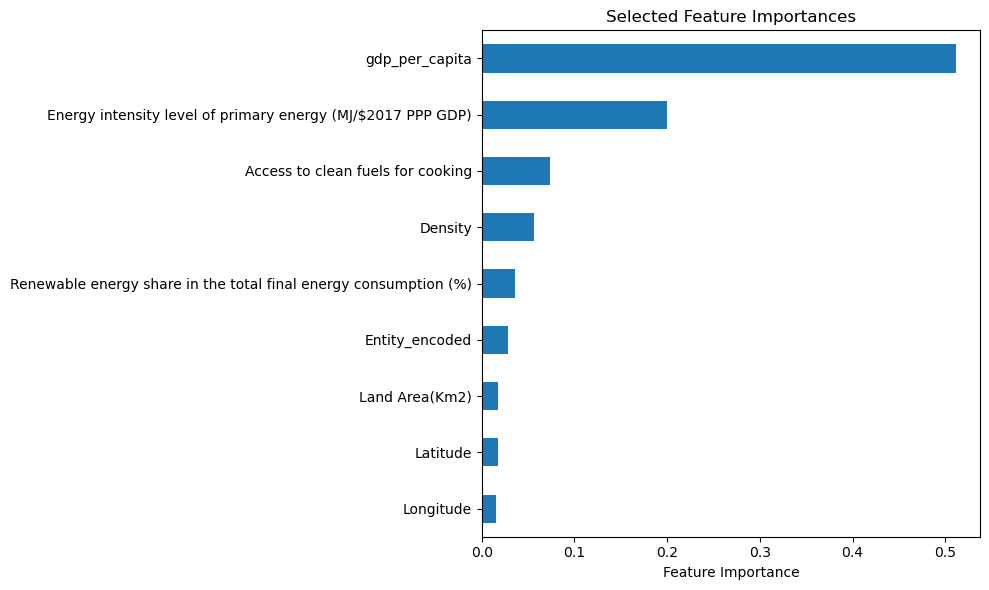

In [10]:
#feature selection using model-based approach
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42), threshold='median')
features = selector.fit_transform(X, y)
selected = selector.get_support()

selected_features = X.columns[selected].tolist()

#print selected features with numbering
print("\n--- Model-based Selection ---")
for i, feature in enumerate(selected_features, 1):
    print(f"{i}. {feature}")
    

X_selected = X[selected_features]

#visualize selected features using bar plot
feature_importances = selector.estimator_.feature_importances_[selected]
feature_importances = pd.Series(feature_importances, index=selected_features).sort_values()
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Selected Feature Importances')
plt.tight_layout()
plt.show()



In [11]:
train = df.loc[df.Year < 2017]
test = df.loc[df.Year >= 2017]

Target = 'Primary energy consumption per capita (kWh/person)'

X_train = train[X_selected.columns]
y_train = train[Target]

X_test = test[X_selected.columns]
y_test = test[Target]

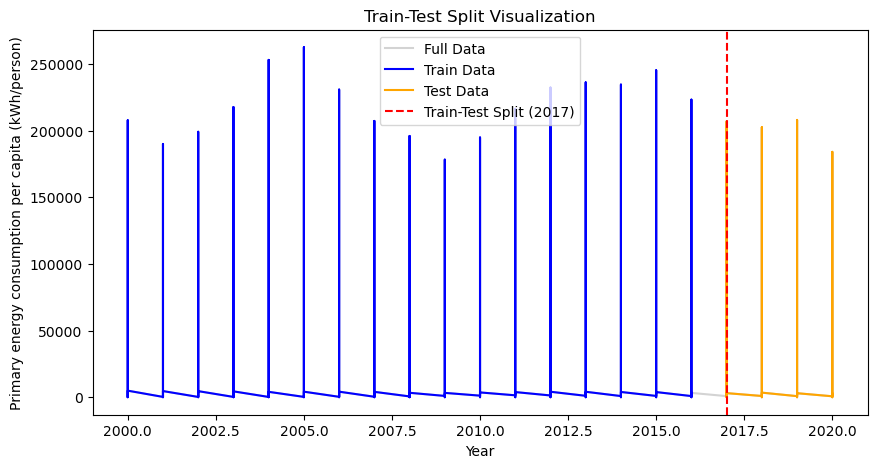

In [12]:
#add visualization for train and test split u
plt.figure(figsize=(10, 5))
plt.plot(df['Year'], df[Target], label='Full Data', color='lightgray')
plt.plot(train['Year'], y_train, label='Train Data', color='blue')
plt.plot(test['Year'], y_test, label='Test Data', color='orange')
plt.axvline(x=2017, color='red', linestyle='--', label='Train-Test Split (2017)')
plt.xlabel('Year')
plt.ylabel(Target)
plt.title('Train-Test Split Visualization')
plt.legend()
plt.show()

*Part 2: Model Training*  

In [13]:
X_train, X_test, y_train, y_test= split(X_selected, y, test_size= 0.2, random_state=42)

In [14]:
#model definition
results= []
models={}
models['lnr'] =LinearRegression()
models['knn'] =KNeighborsRegressor()
models['rfr'] =RandomForestRegressor()
models['mpr'] =MLPRegressor()
models['gbr'] =GradientBoostingRegressor()
models['dtr'] =DecisionTreeRegressor()
models['rrn'] =Ridge()
models['svr'] =SVR()

In [15]:
kf= KFold(n_splits=5, shuffle= True, random_state=42)

In [16]:
#define a list
result_cp= []
#before scaling
for n in models:
    scores= cross_val_score(models[n], X_train, y_train, cv=kf, n_jobs=-1)
    print(f'model: {n} {scores.mean():.3f} +/- {scores.std():.3f}')

    result_cp.append({
        'Model': n,
        'R2 Mean': scores.mean()
    })

model: lnr 0.638 +/- 0.020
model: knn 0.879 +/- 0.026
model: rfr 0.979 +/- 0.006
model: mpr 0.546 +/- 0.039
model: gbr 0.965 +/- 0.002
model: dtr 0.960 +/- 0.014
model: rrn 0.638 +/- 0.020
model: svr -0.132 +/- 0.011


In [17]:

cp_df= pd.DataFrame(result_cp)
cp_df

,Model,R2 Mean
0,lnr,0.637814
1,knn,0.879285
2,rfr,0.979056
3,mpr,0.545780
4,gbr,0.965457
5,dtr,0.959647
6,rrn,0.637814
7,svr,-0.132335


In [18]:
#Scaler defination
scalers ={}
scalers['mms']= MinMaxScaler()
scalers['std']= StandardScaler()
scalers['rbs']= RobustScaler()


In [19]:
#finding the best scaler
results= []
#for loop scaler
for s in scalers:
    X_train_scaled= scalers[s].fit_transform(X_train)
    X_test_scaled= scalers[s].transform(X_test)
    print(f'---- With {s} scaling: ----\n')
    #model for loop
    for n in models:
        scores= cross_val_score(models[n], X_train_scaled, y_train ,cv= kf, n_jobs=-1)
        print(f'Models: {n}: {scores.mean():.3f} +/- {scores.std():.3f}')
        results.append({
            'Scaler': s, 
            'Model': n, 
            'R2 Mean':scores.mean()
            })

---- With mms scaling: ----

Models: lnr: 0.638 +/- 0.020
Models: knn: 0.980 +/- 0.003
Models: rfr: 0.976 +/- 0.008
Models: mpr: -0.436 +/- 0.037
Models: gbr: 0.965 +/- 0.003
Models: dtr: 0.957 +/- 0.014
Models: rrn: 0.638 +/- 0.021
Models: svr: -0.128 +/- 0.011
---- With std scaling: ----

Models: lnr: 0.638 +/- 0.020
Models: knn: 0.979 +/- 0.004
Models: rfr: 0.978 +/- 0.007
Models: mpr: -0.379 +/- 0.038
Models: gbr: 0.965 +/- 0.003
Models: dtr: 0.950 +/- 0.023
Models: rrn: 0.638 +/- 0.020
Models: svr: -0.128 +/- 0.011
---- With rbs scaling: ----

Models: lnr: 0.638 +/- 0.020
Models: knn: 0.971 +/- 0.005
Models: rfr: 0.978 +/- 0.007
Models: mpr: -0.254 +/- 0.019
Models: gbr: 0.965 +/- 0.002
Models: dtr: 0.950 +/- 0.022
Models: rrn: 0.638 +/- 0.020
Models: svr: -0.128 +/- 0.011


In [20]:
#Rearrange the result from high to low
result_df= pd.DataFrame(results)

result_sort= result_df.sort_values(by='R2 Mean', ascending= False)
print(result_sort)

   Scaler Model   R2 Mean
1     mms   knn  0.979975
9     std   knn  0.979095
18    rbs   rfr  0.978107
10    std   rfr  0.977875
2     mms   rfr  0.975875
17    rbs   knn  0.971100
4     mms   gbr  0.965347
20    rbs   gbr  0.965273
12    std   gbr  0.965185
5     mms   dtr  0.957269
13    std   dtr  0.950100
21    rbs   dtr  0.949574
6     mms   rrn  0.638005
14    std   rrn  0.637825
22    rbs   rrn  0.637817
8     std   lnr  0.637814
0     mms   lnr  0.637814
16    rbs   lnr  0.637814
7     mms   svr -0.127698
15    std   svr -0.128097
23    rbs   svr -0.128412
19    rbs   mpr -0.254243
11    std   mpr -0.378636
3     mms   mpr -0.436327


In [21]:
#MinMaxScaler choose as the scaler
scl= MinMaxScaler()
Xs_train= scl.fit_transform(X_train)
Xs_test= scl.transform(X_test)

KNN Performance Before Tuning

R2 Score: 0.974
RMSE: 5641.293


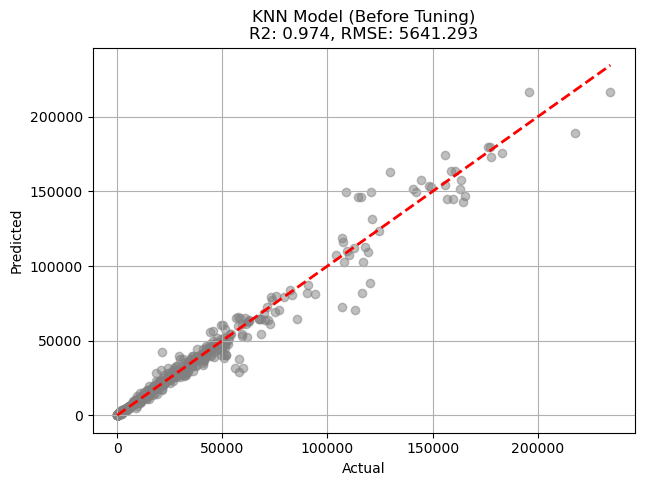

In [22]:
#Using the result from scaler
#redo again the model training
#check the performance
knn_bt =KNeighborsRegressor()
knn_bt.fit(X_train_scaled, y_train)

y_predb= knn_bt.predict(X_test_scaled)

r2b= r2_score(y_test, y_predb)
rmseb= np.sqrt(mean_squared_error(y_test, y_predb))

print(f"KNN Performance Before Tuning\n")
print(f"R2 Score: {r2b:.3f}")
print(f"RMSE: {rmseb:.3f}")


plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_predb, color='gray', alpha=0.5) 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'KNN Model (Before Tuning)\nR2: {r2b:.3f}, RMSE: {rmseb:.3f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

In [23]:
#hyperparameter tuning using for loop
#by changing the range in k and type of weight
k_range = range(1,22,2)
wght = ['uniform', 'distance']

print(f"{'K Value':<10} | {'Weight Type':<15} | {'R2 Score (Test)':<15}")
print("-" * 45)

results_hp = []

for k in k_range:
    for w in wght:
        knn_hp = KNeighborsRegressor(n_neighbors=k, weights=w)
        knn_hp.fit(X_train_scaled, y_train)

        kscores= knn_hp.score(X_test_scaled, y_test)
        
        print(f"{k:<10} | {w:<15} | {kscores:.3f}")
        
        results_hp.append({'K': k, 
                        'Weight': w, 
                        'R2 Score': kscores})

K Value    | Weight Type     | R2 Score (Test)
---------------------------------------------
1          | uniform         | 0.982
1          | distance        | 0.982
3          | uniform         | 0.982
3          | distance        | 0.984
5          | uniform         | 0.974
5          | distance        | 0.981
7          | uniform         | 0.970
7          | distance        | 0.980
9          | uniform         | 0.967
9          | distance        | 0.979
11         | uniform         | 0.962
11         | distance        | 0.978
13         | uniform         | 0.957
13         | distance        | 0.977
15         | uniform         | 0.947
15         | distance        | 0.974
17         | uniform         | 0.935
17         | distance        | 0.972
19         | uniform         | 0.915
19         | distance        | 0.968
21         | uniform         | 0.896
21         | distance        | 0.965


In [24]:
resulthp= pd.DataFrame(results_hp)
resulthp_sort= resulthp.sort_values(by='R2 Score', ascending= False)
print(resulthp_sort)

     K    Weight  R2 Score
3    3  distance  0.984382
0    1   uniform  0.981981
1    1  distance  0.981981
2    3   uniform  0.981648
5    5  distance  0.981203
7    7  distance  0.979685
9    9  distance  0.979457
11  11  distance  0.977660
13  13  distance  0.976683
4    5   uniform  0.974495
15  15  distance  0.974152
17  17  distance  0.972063
6    7   uniform  0.969683
19  19  distance  0.968174
8    9   uniform  0.967349
21  21  distance  0.964600
10  11   uniform  0.962252
12  13   uniform  0.957139
14  15   uniform  0.946798
16  17   uniform  0.935092
18  19   uniform  0.914642
20  21   uniform  0.895685


Tuning KNN
Fitting 5 folds for each of 44 candidates, totalling 220 fits

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Final R2 Score: 0.988
Final RMSE: 3820.210


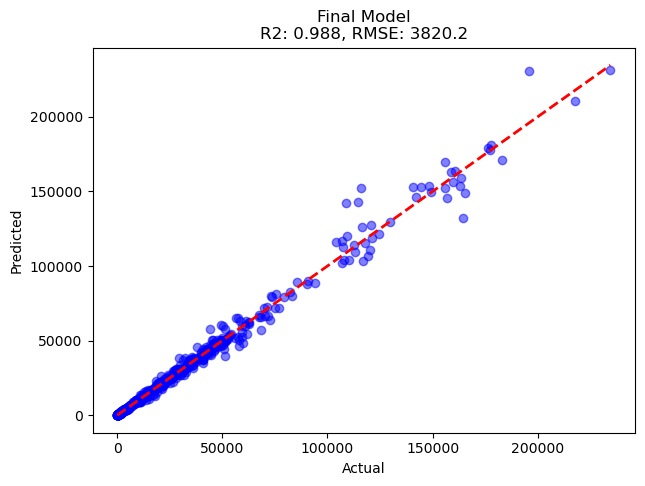

In [25]:
#hyperparameter tuning using GridSearchCV
knn_pg= { 'n_neighbors': list(range(1,22,2)),
         'weights': ['uniform','distance'],
         'metric': ['euclidean','manhattan']
}
grid_knn_pghp= GridSearchCV(estimator=KNeighborsRegressor(),
                          param_grid=knn_pg, 
                          cv=kf, scoring='r2',n_jobs=-1, verbose=1)
print("Tuning KNN")
grid_knn_pghp.fit(X_train_scaled, y_train)

best_knn= grid_knn_pghp.best_estimator_
y_pred= best_knn.predict(X_test_scaled)

fr2= r2_score(y_test, y_pred)
frmse= np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nBest Parameters: {grid_knn_pghp.best_params_}")
print(f"Final R2 Score: {fr2:.3f}")
print(f"Final RMSE: {frmse:.3f}")

#draw graph
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Final Model\nR2: {fr2:.3f}, RMSE: {frmse:.1f}')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [26]:
#final model test

y_pred= grid_knn_pghp.predict(X_test_scaled)
fscores= grid_knn_pghp.score(X_test_scaled, y_test)
fmae= mean_absolute_error(y_test, y_pred)
frmse= np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Final Test RMSE: {frmse:.3f}')
print(f'Final MAE: {fmae:.3f}')
print(f'R2: {fscores:.3f} ')

Final Test RMSE: 3820.210
Final MAE: 1536.275
R2: 0.988 
